In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score as accuracy , recall_score as recall , precision_score as precision , f1_score as f1, classification_report

In [2]:
review_dataset = pd.read_csv("/kaggle/input/imdb-review-dataset/imdb_master.csv",encoding='latin-1')
review_dataset.head(5)

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [3]:
review_dataset = review_dataset.drop(columns=['Unnamed: 0','file']).reset_index(drop=True)

In [4]:
print(review_dataset['type'].value_counts())

type
train    75000
test     25000
Name: count, dtype: int64


In [5]:
review_dataset['label'].value_counts()

label
unsup    50000
neg      25000
pos      25000
Name: count, dtype: int64

In [6]:
review_dataset.head(5)

,type,review,label
0,test,Once again Mr. Costner has dragged out a movie...,neg
1,test,This is an example of why the majority of acti...,neg
2,test,"First of all I hate those moronic rappers, who...",neg
3,test,Not even the Beatles could write songs everyon...,neg
4,test,Brass pictures (movies is not a fitting word f...,neg


### Check the Percentage of Training & Test data

In [7]:
type_reviews = review_dataset['type'].value_counts(normalize=True)*100

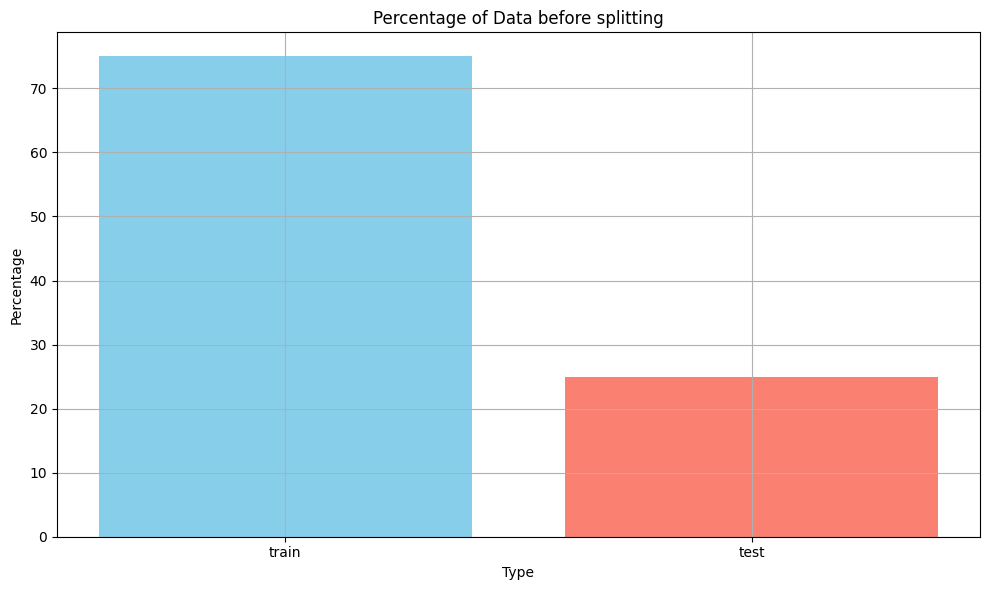

type
train    75.0
test     25.0
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(10,6))
plt.bar(type_reviews.index,type_reviews.values,color=['skyblue','salmon'])
plt.title("Percentage of Data before splitting")
plt.xlabel("Type")
plt.ylabel("Percentage")
plt.grid(True)
plt.tight_layout()
plt.show()
print(type_reviews)

### Preprocess data 

In [9]:
def clean_html_tags(text):
    if not isinstance(text,str):
        return ""
    text = re.sub(r'<br\s*/?>',' ',text)
    text = re.sub(r'<.*?>',' ',text)
    text = re.sub(r'\s+',' ',text).lower().strip()
    return text

In [10]:
review_dataset['review'] = review_dataset['review'].apply(clean_html_tags)

### Split Data to Training and Test

In [11]:
review_col = 'review'
label_col = 'label'
type_col = 'type'
valid_labels = ['pos','neg']

In [12]:
train_df = review_dataset[review_dataset[type_col]=='train'].copy()
test_df = review_dataset[review_dataset[type_col]=='test'].copy()


In [13]:
valid_labels = ['pos','neg']
train_df = train_df[train_df[label_col].isin(valid_labels)].copy()
test_df = test_df[test_df[label_col].isin(valid_labels)].copy()

In [14]:
len(train_df),len(test_df)

(25000, 25000)

In [15]:
X_train = train_df['review']
y_train = train_df['label']
X_test = test_df['review']
y_test = test_df['label']

In [16]:
y_train

25000    neg
25001    neg
25002    neg
25003    neg
25004    neg
        ... 
49995    pos
49996    pos
49997    pos
49998    pos
49999    pos
Name: label, Length: 25000, dtype: object

In [17]:
label_map = {"neg":0,"pos":1}
y_train = y_train.map(label_map)
y_test = y_test.map(label_map)

In [18]:
print(y_train.isnull().sum())
print(y_test.isnull().sum())

0
0


### Pipeline Creation for TFIDF and MLP

In [19]:
model = Pipeline([
    ("tfidf",TfidfVectorizer(
        max_features=40000,
        ngram_range=(1,2),
        stop_words='english'
    )),
    ("mlp",MLPClassifier(
        hidden_layer_sizes=(256,128,64),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        alpha=1e-3,
        batch_size=64,
        max_iter=50,
        random_state=42
    ))
])


In [20]:
model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=40000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mlp',
                 MLPClassifier(alpha=0.001, batch_size=64,
                               hidden_layer_sizes=(256, 128, 64),
                               learning_rate='adaptive', max_iter=50,
                               random_state=42))])

In [21]:
model.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=40000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mlp',
                 MLPClassifier(alpha=0.001, batch_size=64,
                               hidden_layer_sizes=(256, 128, 64),
                               learning_rate='adaptive', max_iter=50,
                               random_state=42))])

In [22]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.84      0.87      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [23]:
import joblib 

joblib.dump(model,"mlp_classifier.pkl")

['mlp_classifier.pkl']